✅ Model loaded successfully!
Click the 'Capture & Predict' button below to snap a photo!


<IPython.core.display.Javascript object>


🎯 Prediction: 1 (Confidence: 99.91%)


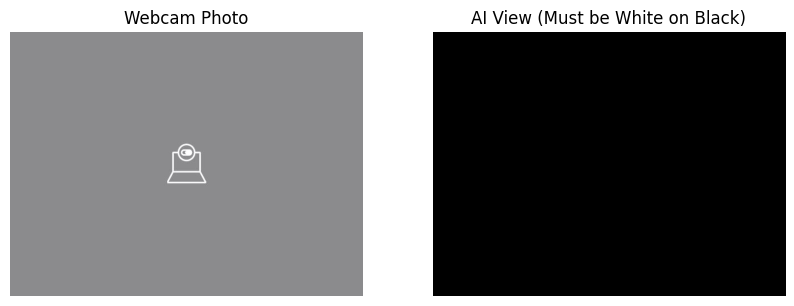

In [4]:
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# --- 1. Load the Model ---
try:
    model = tf.keras.models.load_model('mnist_custom_cnn_99acc.h5')
    print("✅ Model loaded successfully!")
except:
    print("❌ Model not found! Please drag and drop 'mnist_custom_cnn_99acc.h5' into the Files tab on the left.")

# --- 2. JavaScript Helper to Access Webcam ---
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture & Predict';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# --- 3. Preprocessing Function ---
def predict_digit(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Preprocess (Grayscale -> Blur -> Threshold -> Resize -> Normalize)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # Invert colors (White text on black background)
    _, thresh = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Resize to 28x28 for the model
    resized = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)
    processed = resized.astype('float32') / 255.0
    processed = processed.reshape(1, 28, 28, 1)

    # Predict
    prediction = model.predict(processed, verbose=0)
    digit = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    return img, thresh, digit, confidence

# --- 4. RUN THE CAMERA ---
print("Click the 'Capture & Predict' button below to snap a photo!")
try:
    filename = take_photo()

    # Get predictions
    original_img, processed_view, digit, conf = predict_digit(filename)

    # Display Results
    print(f"\n🎯 Prediction: {digit} (Confidence: {conf:.2f}%)")

    # Show images side-by-side
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Webcam Photo")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_view, cmap='gray')
    plt.title("AI View (Must be White on Black)")
    plt.axis('off')

    plt.show()

except Exception as e:
    print(str(e))